CELL 1 — Imports + seeds

In [1]:
# Operating system utilities
import os

# Array handling
import numpy as np

# Pickle for loading normalization stats
import pickle

# EEG preprocessing libraries
import mne
import pywt

# Machine learning utilities
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

# Reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Imports loaded and seeds set.")


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


✅ Imports loaded and seeds set.


CELL 2 — Load trained model + normalization stats

In [3]:
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, 
                                     Activation, MaxPooling2D, Dropout,
                                     Flatten, Dense, Lambda, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm

# ========================================================================
# STEP 1: Define the model architecture (same as training)
# ========================================================================

def create_shallowconvnet(input_shape, dropout_rate=0.5, num_classes=1):
    """
    ShallowConvNet implementation - must match the trained model exactly
    """
    n_channels = input_shape[0]
    
    # INPUT LAYER
    inputs = Input(shape=input_shape)
    
    # CONVOLUTION 1 (5x5x32)
    x = Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding='valid',
        use_bias=False,
        kernel_constraint=max_norm(2.)
    )(inputs)
    
    # MAX POOL 1
    x = MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='valid'
    )(x)
    
    # CONVOLUTION 2 (5x5x64)
    x = Conv2D(
        filters=64,
        kernel_size=(5, 5),
        padding='valid',
        use_bias=False,
        kernel_constraint=max_norm(2.)
    )(x)
    
    # MAX POOL 2
    x = MaxPooling2D(
        pool_size=(3, 3),
        strides=(2, 2),
        padding='valid'
    )(x)
    
    # CONVOLUTION 3 (3x3x128)
    x = Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding='valid',
        use_bias=False,
        kernel_constraint=max_norm(2.)
    )(x)
    
    # MAX POOL 3
    x = MaxPooling2D(
        pool_size=(3, 3),
        strides=(2, 2),
        padding='valid'
    )(x)
    
    # FLATTEN
    x = Flatten()(x)
    
    # FULLY CONNECTED WITH MAXOUT (4608 → 2304)
    x = Dense(4608, kernel_constraint=max_norm(2.))(x)
    x = Reshape((-1, 2))(x)
    x = Lambda(lambda z: tf.reduce_max(z, axis=-1))(x)
    
    # DROPOUT
    x = Dropout(dropout_rate)(x)
    
    # OUTPUT LAYER
    outputs = Dense(
        num_classes,
        activation='sigmoid',
        kernel_constraint=max_norm(0.5)
    )(x)
    
    # CREATE MODEL
    model = Model(inputs=inputs, outputs=outputs, name="ShallowConvNet")
    
    # COMPILE
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5)]
    )
    
    return model


# ========================================================================
# STEP 2: Load the trained model
# ========================================================================

# Paths (update these to your actual paths)
MODEL_PATH = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\ad_shallowconvnet_final.keras"
MEAN_PATH  = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\train_mean.pkl"
STD_PATH   = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\train_std.pkl"

print("=" * 80)
print("LOADING PRE-TRAINED MODEL")
print("=" * 80)

# Method 1: Try loading with compile=False (often works)
try:
    print("\n[Method 1] Attempting to load model with compile=False...")
    model = keras.models.load_model(MODEL_PATH, compile=False)
    print("✅ Model loaded successfully with compile=False!")
    
    # Recompile the model
    print("\nRecompiling model...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5)]
    )
    print("✅ Model recompiled successfully!")
    
except Exception as e:
    print(f"❌ Method 1 failed: {e}")
    print("\n[Method 2] Recreating architecture and loading weights...")
    
    try:
        # Recreate the model architecture
        input_shape = (127, 100, 1)
        model = create_shallowconvnet(input_shape, dropout_rate=0.5, num_classes=1)
        print("✅ Model architecture recreated!")
        
        # Load the trained weights
        # First, try to load the full model just to extract weights
        try:
            temp_model = keras.models.load_model(MODEL_PATH, compile=False)
            model.set_weights(temp_model.get_weights())
            print("✅ Weights transferred successfully!")
        except:
            # If that fails, try loading weights directly
            model.load_weights(MODEL_PATH)
            print("✅ Weights loaded successfully!")
            
    except Exception as e2:
        print(f"❌ Method 2 also failed: {e2}")
        print("\n[Method 3] Trying with safe_mode=False...")
        
        try:
            # Last resort: load with safe_mode=False and compile=False
            model = keras.models.load_model(MODEL_PATH, safe_mode=False, compile=False)
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5)]
            )
            print("✅ Model loaded with safe_mode=False!")
        except Exception as e3:
            print(f"❌ All methods failed. Final error: {e3}")
            raise


# ========================================================================
# STEP 3: Load normalization parameters
# ========================================================================

print("\n" + "=" * 80)
print("LOADING NORMALIZATION PARAMETERS")
print("=" * 80)

with open(MEAN_PATH, "rb") as f:
    train_mean = pickle.load(f)
print("✅ Training mean loaded.")

with open(STD_PATH, "rb") as f:
    train_std = pickle.load(f)
print("✅ Training std loaded.")


# ========================================================================
# STEP 4: Verify model is ready
# ========================================================================

print("\n" + "=" * 80)
print("MODEL READY FOR INFERENCE")
print("=" * 80)

print("\nModel Summary:")
model.summary()

print("\n" + "=" * 80)
print("✅ SETUP COMPLETE - You can now use the model for predictions!")
print("=" * 80)

print("\nExample usage:")
print("  # Normalize your data")
print("  X_normalized = (X_test - train_mean) / train_std")
print("  # Make predictions")
print("  predictions = model.predict(X_normalized)")

LOADING PRE-TRAINED MODEL

[Method 1] Attempting to load model with compile=False...
❌ Method 1 failed: The `function` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().

[Method 2] Recreating architecture and loading weights...

✅ Model architecture recreated!
✅ Weights loaded successfully!

LOADING NORMALIZATION PARAMETERS
✅ Training mean loaded.
✅ Training std loaded.

MODEL READY FOR INFERENCE

Model Summary:


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "ShallowConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 127, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 123, 96, 32)    │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 61, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 44, 64)     │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 19, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    63,705,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2304, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,833,633 (243.51 MB)

 Trainable params: 63,833,633 (243.51 MB)

 Non-trainable params: 0 (0.00 B)


✅ SETUP COMPLETE - You can now use the model for predictions!

Example usage:
  # Normalize your data
  X_normalized = (X_test - train_mean) / train_std
  # Make predictions
  predictions = model.predict(X_normalized)


CELL 3 — Load ONLY excluded trials

In [4]:
# Local EEG data paths
NEG_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_negative.npy"
POS_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_positive.npy"

# Load full arrays
X_neg_full = np.load(NEG_PATH).astype(np.float32)
X_pos_full = np.load(POS_PATH).astype(np.float32)

print("✅ EEG arrays loaded.")
print("Negative shape:", X_neg_full.shape)
print("Positive shape:", X_pos_full.shape)

# Extract ONLY last 5 trials (excluded during training)
X_neg_excluded = X_neg_full[-5:]
X_pos_excluded = X_pos_full[-5:]

print("✅ Extracted excluded trials:")
print("Excluded negative:", X_neg_excluded.shape)
print("Excluded positive:", X_pos_excluded.shape)


✅ EEG arrays loaded.
Negative shape: (31, 127, 150000)
Positive shape: (46, 127, 150000)
✅ Extracted excluded trials:
Excluded negative: (5, 127, 150000)
Excluded positive: (5, 127, 150000)


CELL 4 — Select ONLY last ad_negative sample (target = 0)

In [37]:
# Select ONLY the last excluded negative trial
X_test_trial = X_neg_excluded[-5]
y_test_trial = 0  # Ground truth label

print("✅ Selected last excluded ad_negative trial.")
print("Trial shape:", X_test_trial.shape)
print("Ground truth label:", y_test_trial)


✅ Selected last excluded ad_negative trial.
Trial shape: (127, 150000)
Ground truth label: 0


* down sampling

In [38]:
# --- Downsample from 1000 Hz -> 500 Hz (keep output name: X_test_trial) ---
sfreq_in = 1000
sfreq_out = 500

X_test_trial = mne.filter.resample(
    X_test_trial.astype(np.float64, copy=False),
    down=sfreq_in // sfreq_out,   # 2
    npad="auto",
    axis=-1,
    verbose=True
).astype(np.float32, copy=False)

print("✅ Downsampled X_test_trial to 500 Hz.")
print("Trial shape after downsampling:", X_test_trial.shape, X_test_trial.dtype)


✅ Downsampled X_test_trial to 500 Hz.
Trial shape after downsampling: (127, 75000) float32


CELL 5 — Helper + preprocessing classes

In [39]:
# Helper to generate channel names
def _names_from_index_mapping(n_channels, index_to_name):
    return [f"EEG{i+1}" for i in range(n_channels)]

# Helper to create MNE Raw object
def _make_raw(eeg, sfreq, ch_names):
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    return mne.io.RawArray(eeg, info, verbose=False)

# Wavelet ICA class
class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.ica = None

    def fit(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        self.ica = FastICA(n_components=min(self.n_components, X.shape[0]), random_state=42)
        S = self.ica.fit_transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        pywt.waverec(coeffs, self.wavelet, axis=1)

    def transform(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        S = self.ica.transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        return pywt.waverec(coeffs, self.wavelet, axis=1)

print("✅ Preprocessing helpers defined.")


✅ Preprocessing helpers defined.


CELL 6 — Apply preprocessing to unseen test trial

In [40]:
# Sampling frequency (same as training)
fs = 500.0

# Create Raw object
raw = _make_raw(X_test_trial, fs, _names_from_index_mapping(X_test_trial.shape[0], None))

# Notch filtering
raw.notch_filter([50, 100, 150], verbose=False)

# High-pass filtering
raw.filter(l_freq=0.05, h_freq=None, verbose=False)

# Common average reference
raw.set_eeg_reference("average", projection=True)
raw.apply_proj()

# Extract cleaned signal
X_clean = raw.get_data().astype(np.float32)

print("✅ Preprocessing applied.")
print("Cleaned trial shape:", X_clean.shape)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ Preprocessing applied.
Cleaned trial shape: (127, 75000)


CELL 7 — Segment test trial

In [41]:
# Segment size
SEGMENT_SIZE = 100

# Segment the trial
segments = []
for i in range(X_clean.shape[1] // SEGMENT_SIZE):
    seg = X_clean[:, i*SEGMENT_SIZE:(i+1)*SEGMENT_SIZE]
    segments.append(seg)

# Convert to array
X_test_segments = np.array(segments, dtype=np.float32)

print("✅ Trial segmented.")
print("Segments shape:", X_test_segments.shape)


✅ Trial segmented.
Segments shape: (750, 127, 100)


CELL 8 — Reshape + normalize using TRAINING stats

In [42]:
# Add channel dimension
X_test = X_test_segments[..., np.newaxis]

# Normalize using training mean/std
X_test_norm = (X_test - train_mean) / train_std

print("✅ Normalization applied using training statistics.")
print("Final test shape:", X_test_norm.shape)


✅ Normalization applied using training statistics.
Final test shape: (750, 127, 100, 1)


CELL 9 — Run inference

In [43]:
# Predict probabilities
y_probs = model.predict(X_test_norm, verbose=0)

# Convert to binary predictions
y_preds = (y_probs >= 0.5).astype(int).flatten()

# True labels
y_true = np.zeros_like(y_preds)

print("✅ Inference completed.")
print("Predicted labels:", y_preds[:10])


✅ Inference completed.
Predicted labels: [0 0 0 0 0 0 0 0 0 0]


CELL 10 — Confusion matrix plot

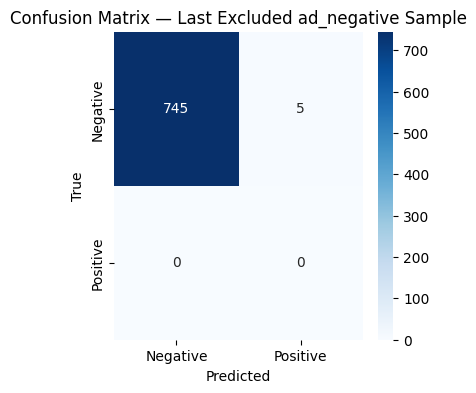

✅ Confusion matrix plotted.


In [44]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_preds)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Last Excluded ad_negative Sample")
plt.show()

print("✅ Confusion matrix plotted.")
